# SVR Model : JNJ (Full)

####  Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import style
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
style.use("fivethirtyeight")

# 1. Importing dataset

In [2]:
JNJ_partial_ds=pd.read_csv('dataset/JNJ.csv')

### 1.1 Remove rows with outliers

In [3]:
open0jnj = JNJ_partial_ds[JNJ_partial_ds['Open'] == 0]
print(open0jnj)

#Remove rows with outliers
JNJ_partial_ds = JNJ_partial_ds.loc[JNJ_partial_ds['Date'] > '1969-12-31']

            Date  Open      High       Low     Close   Volume  Dividends  \
0     1962-01-02   0.0  0.067334  0.066985  0.067334        0        0.0   
1     1962-01-03   0.0  0.066636  0.066287  0.066287   345600        0.0   
2     1962-01-04   0.0  0.066636  0.065589  0.065589   216000        0.0   
3     1962-01-05   0.0  0.065066  0.064543  0.064543   129600        0.0   
4     1962-01-08   0.0  0.064019  0.063496  0.063496   172800        0.0   
...          ...   ...       ...       ...       ...      ...        ...   
1982  1969-12-24   0.0  0.384985  0.374794  0.384985  1080000        0.0   
1983  1969-12-26   0.0  0.396308  0.390080  0.392911   792000        0.0   
1984  1969-12-29   0.0  0.400837  0.395176  0.396308  1454400        0.0   
1985  1969-12-30   0.0  0.403101  0.399138  0.403101   864000        0.0   
1986  1969-12-31   0.0  0.409895  0.403667  0.407631  1411200        0.0   

      Stock Splits  
0              0.0  
1              0.0  
2              0.0  
3  

### 1.2 Create Average column

In [4]:
average=(JNJ_partial_ds['Open']+JNJ_partial_ds['High']+JNJ_partial_ds['Low']+JNJ_partial_ds['Close'])/4
y=average.values
JNJ_partial_ds.insert(8, "Average", average, True)

### 1.3 Drop OHLC column

In [5]:
#Drop columns - Date,Volume,Dividends,Stock Splits 
df=JNJ_partial_ds.drop(['Open', 'High', 'Low', 'Close','Dividends','Stock Splits','Volume'], axis=1)
JNJ_partial_ds_Ori=df
JNJ_partial_ds1=df

In [6]:
df

Date     Average
1987   1970-01-02    0.402818
1988   1970-01-05    0.392769
1989   1970-01-06    0.391071
1990   1970-01-07    0.394326
1991   1970-01-08    0.395742
...           ...         ...
15231  2022-07-06  178.305004
15232  2022-07-07  178.247498
15233  2022-07-08  178.592503
15234  2022-07-11  178.147503
15235  2022-07-12  176.869999

[13249 rows x 2 columns]

In [7]:
#Pick up only 'Average' column
JNJ_partial_ds1=df.reset_index()['Average'] 

### 1.4 Dateset Size

In [8]:
JNJ_partial_ds1.shape 

(13249,)

# 2. Data Preprocessing

To build a SVR model, we need to separate our stock prices data into a training set and a test set. Besides, we will also normalize our data so that all the values are in the same scale.

### 2.1 MinMaxScaler 

Use the Scikit-Learn MinMaxScaler to normalize all our stock data ranging from 0 to 1. We also reshape our normalized data into a two-dimensional array.

In [9]:
#Use MinMaxScaler to scale the data range to 0 and 1
scaler=MinMaxScaler(feature_range=(0,1))
JNJ_partial_ds1=scaler.fit_transform(np.array(JNJ_partial_ds1).reshape(-1,1)) #Fit to data, then transform it

#### Exclude 30 days data 

In [10]:
JNJ_partial_ds1_Future=JNJ_partial_ds1[-30:]
JNJ_partial_ds1=JNJ_partial_ds1[:-30] #Exclude 30 days

In [11]:
#df1 have already converted to array and have the values between 0 to 1
JNJ_partial_ds1

array([[7.69459307e-04],
       [7.14752603e-04],
       [7.05507376e-04],
       ...,
       [9.80521746e-01],
       [9.79528203e-01],
       [9.78575531e-01]])

In [12]:
len(JNJ_partial_ds1)

13219

### 2.2 Preparation of Training and Testing set

- We cannot use Cross Validation or Random Seed to split train and test because stock price always depent on previous date.
- Here we will only need the average prices from our dataset to train our (SVR) model. We are going to extract 80% of the average prices from our acquired stock data as our training set.

In [13]:
training_size=int(len(JNJ_partial_ds1)*0.8) #Split train into 80%
test_size=len(JNJ_partial_ds1)-training_size 
train_data,test_data=JNJ_partial_ds1[0:training_size,:],JNJ_partial_ds1[training_size:len(JNJ_partial_ds1),:1]

#### Training and Testing size 

In [14]:
training_size,test_size

(10575, 2644)

In [15]:
#Convert an array of values into a dataset matrix
def create_dataset(dataset,time_step=1): #timestep default is 1,more better timestep
    dataX,dataY=[],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0] #i=0 to 99(X_train) 100..(y_train)
        print(len(a))
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
        print(f'({i})')
        print(f'DataX \n----------------\n {a}\n')
        print(f'DataY \n----------------\n {dataset[i+time_step,0]}\n')
        print('========================================================')
    return np.array(dataX),np.array(dataY) #Return as array

In [16]:
#Reshape into X=t,t+1,t+2..t+99 and Y=t+100
#Converting independent and dependent feature based on time steps
time_step=100 #Predict based on 100 days
X_train,y_train=create_dataset(train_data,time_step)
X_test,ytest=create_dataset(test_data,time_step)

100
(0)
DataX 
----------------
 [7.69459307e-04 7.14752603e-04 7.05507376e-04 7.23227746e-04
 7.30934086e-04 7.54047931e-04 7.27849641e-04 7.26311305e-04
 7.44804555e-04 7.60216045e-04 7.58673682e-04 7.42491971e-04
 7.21687049e-04 7.34014823e-04 7.40178817e-04 7.40951274e-04
 7.30934615e-04 7.17061961e-04 6.41551791e-04 5.50626655e-04
 5.15184069e-04 5.84531868e-04 6.38468167e-04 5.49088792e-04
 5.64496885e-04 5.89154648e-04 6.59273777e-04 7.17063714e-04
 7.00882441e-04 6.55035734e-04 5.86842222e-04 5.77450592e-04
 5.49273112e-04 5.46570524e-04 5.41552291e-04 5.12989190e-04
 4.76708413e-04 4.90218663e-04 4.94849670e-04 5.26114488e-04
 5.43870188e-04 5.21867572e-04 5.44254408e-04 5.48115713e-04
 5.31132364e-04 5.07200524e-04 4.89831338e-04 4.99480930e-04
 5.12605541e-04 4.97164886e-04 4.74779658e-04 4.57022388e-04
 4.61655856e-04 4.77864993e-04 4.72461147e-04 4.64743941e-04
 4.48918266e-04 4.94079028e-04 5.11062522e-04 5.06431679e-04
 4.84813581e-04 4.73620030e-04 4.48919484e-04 4.4467


DataY 
----------------
 0.001961112414090525

100
(334)
DataX 
----------------
 [0.0016715  0.00169016 0.00170648 0.00170299 0.001668   0.00173214
 0.00184992 0.00192222 0.00193155 0.00191289 0.0018989  0.00188257
 0.00188141 0.00185945 0.0018396  0.00185712 0.00185244 0.00184544
 0.00182676 0.00181509 0.00181742 0.00180108 0.00179641 0.00180108
 0.00184777 0.0018828  0.00189447 0.00189331 0.00186529 0.00184544
 0.00186645 0.00188047 0.00194584 0.00205675 0.00213614 0.00211863
 0.00210462 0.00204741 0.00199488 0.0020229  0.00207893 0.00206376
 0.00203224 0.00207426 0.00218401 0.00218517 0.00217817 0.00213497
 0.00210695 0.00210345 0.0021233  0.00215132 0.00215132 0.00211162
 0.00214898 0.00217233 0.00211629 0.00211863 0.00215132 0.00214315
 0.00220736 0.00223771 0.00214898 0.0021338  0.00208127 0.00207193
 0.00207426 0.00197386 0.00195869 0.00194934 0.00189214 0.00179524
 0.00181625 0.00193417 0.00200772 0.00205091 0.0022202  0.00221553
 0.00215832 0.00209411 0.00210112 0.00213642 0


DataY 
----------------
 0.0032108783042592882

100
(635)
DataX 
----------------
 [0.00320591 0.00324695 0.00324577 0.00321294 0.00322467 0.00325633
 0.00325985 0.00327391 0.00325047 0.00315197 0.00315666 0.00316135
 0.00315666 0.00319183 0.00321294 0.00318714 0.00316369 0.00314259
 0.00314024 0.0031719  0.00319066 0.00318011 0.00322701 0.00323405
 0.0032317  0.00325046 0.00337476 0.00346739 0.00346622 0.00325515
 0.0032575  0.00327039 0.00330909 0.00327999 0.00326356 0.00321192
 0.00320723 0.00319784 0.0031732  0.00315089 0.00317436 0.00319549
 0.00324126 0.00324947 0.00325182 0.00324948 0.00326708 0.00323656
 0.00318611 0.00315794 0.00316263 0.00316968 0.0031509  0.00315559
 0.0031286  0.00316733 0.00316498 0.00313447 0.00313447 0.00320723
 0.00327412 0.00328351 0.0032084  0.00324243 0.00327529 0.00322365
 0.00323657 0.00328937 0.00328937 0.0032706  0.00328702 0.00326473
 0.00323774 0.00322601 0.00325182 0.00325652 0.00324243 0.00321896
 0.00318493 0.00323891 0.00333045 0.00335861 

(932)
DataX 
----------------
 [0.00286728 0.0028661  0.00288732 0.00298867 0.00304287 0.00305466
 0.0030688  0.00308059 0.00310887 0.00314422 0.00311594 0.00310769
 0.00308412 0.00304995 0.00299927 0.00297452 0.00293092 0.00287671
 0.00292974 0.00297099 0.00299102 0.00298631 0.00296746 0.00301224
 0.00304052 0.00304994 0.00303934 0.00302166 0.00304759 0.0030688
 0.00310062 0.00311358 0.00312772 0.00319607 0.0032385  0.00321729
 0.00315954 0.00310651 0.00310297 0.00310298 0.00310416 0.00314658
 0.00319607 0.00315719 0.00313833 0.00312183 0.00311948 0.00309119
 0.00310418 0.00308766 0.00296379 0.00296615 0.00300154 0.00294256
 0.00292604 0.00300036 0.00301924 0.00300508 0.00294492 0.00287178
 0.00275263 0.00277622 0.00289655 0.00300272 0.00306171 0.0028824
 0.00274555 0.0026441  0.00254736 0.0026382  0.00277386 0.00267241
 0.00258511 0.00250489 0.00277976 0.00289655 0.00280925 0.00280454
 0.00279628 0.00280689 0.00271842 0.00251433 0.00239636 0.00227132
 0.00227839 0.00229255 0.00238928

100
(1192)
DataX 
----------------
 [0.00178478 0.00177647 0.00165787 0.00169701 0.00166499 0.00155231
 0.00142896 0.00145624 0.00156655 0.00151317 0.00146336 0.00154994
 0.00150843 0.00153334 0.00172666 0.00175869 0.00188678 0.00189271
 0.00184171 0.00181087 0.00188203 0.00198285 0.00206943 0.00196861
 0.0018595  0.00191287 0.00190813 0.00198285 0.00200182 0.00193778
 0.00188559 0.00183934 0.00190813 0.0019532  0.00192473 0.00192117
 0.00189271 0.00186306 0.00180376 0.0018512  0.00183815 0.00173047
 0.00173285 0.00175187 0.00175781 0.00177327 0.00178159 0.00179348
 0.00180537 0.00177803 0.00172453 0.00167222 0.00162704 0.00159376
 0.00157473 0.00160683 0.0017055  0.00175306 0.00174236 0.00174712
 0.00174355 0.00173998 0.00178516 0.00178635 0.00171977 0.00164844
 0.00160921 0.00163061 0.0016425  0.00162823 0.00164488 0.00170313
 0.00173047 0.00171145 0.00163537 0.00156642 0.00152956 0.00160327
 0.00153075 0.00143802 0.00143445 0.00147012 0.00141306 0.00138096
 0.00142851 0.00139641 0.0

DataX 
----------------
 [0.00208023 0.00207185 0.00207544 0.00211668 0.00214429 0.00212748
 0.00212268 0.00212748 0.00213948 0.00217309 0.00219469 0.00219709
 0.00216709 0.00209508 0.00200148 0.00198348 0.00196308 0.00195348
 0.00197508 0.00199788 0.00203628 0.00203268 0.00201108 0.00202788
 0.00206628 0.00205668 0.00204708 0.00201108 0.00198348 0.00201468
 0.00204468 0.00204348 0.00201708 0.00202188 0.00203628 0.00204948
 0.00207828 0.00209388 0.00208788 0.00209628 0.00212028 0.00212989
 0.00208548 0.00206148 0.00204708 0.00204828 0.00202428 0.00195588
 0.00194388 0.00197388 0.00205908 0.00207348 0.00210948 0.00219709
 0.00225949 0.00224869 0.00225349 0.00223909 0.00216469 0.00213468
 0.00216708 0.00214669 0.00215148 0.00214789 0.00213901 0.00213058
 0.00210289 0.00205232 0.00201982 0.00199935 0.00196203 0.00187534
 0.00187534 0.00185126 0.00186089 0.00185608 0.001832   0.00178143
 0.00176819 0.00178384 0.00187895 0.00191748 0.00194999 0.00195962
 0.00190664 0.00188859 0.0018934  0.0

100
(1775)
DataX 
----------------
 [0.00154659 0.00148706 0.00149314 0.00146763 0.00141904 0.00139839
 0.00138988 0.00136559 0.00134251 0.00133158 0.0013255  0.00128542
 0.00119553 0.00117123 0.00119552 0.00126355 0.00130364 0.00127205
 0.00127327 0.00126355 0.00123804 0.00119674 0.00119431 0.00113965
 0.00113114 0.00116758 0.00117852 0.00116394 0.00115573 0.00117038
 0.00116061 0.00114596 0.00114107 0.00116061 0.00122411 0.00124121
 0.00123266 0.00125709 0.00130227 0.00133769 0.00130105 0.00130105
 0.00133158 0.0013499  0.00138898 0.0013902  0.00139631 0.00138776
 0.00138287 0.00137066 0.00134379 0.00132181 0.00129006 0.00125831
 0.00126197 0.00124488 0.00120335 0.00121557 0.00119725 0.00117771
 0.00117771 0.00117527 0.00116794 0.00117893 0.00119359 0.001229
 0.00122656 0.00121923 0.00120458 0.00122656 0.00122045 0.0011484
 0.00106047 0.00102506 0.00104826 0.00105925 0.00104948 0.00104093
 0.00107024 0.0011081  0.00114352 0.00114596 0.00111176 0.00110077
 0.00106291 0.00103605 0.0010

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



100
(5274)
DataX 
----------------
 [0.02024771 0.02026718 0.02019541 0.02020566 0.02038001 0.02028771
 0.02022617 0.02020566 0.01993902 0.02018514 0.02042103 0.02079023
 0.02123122 0.02182606 0.02185682 0.02173375 0.02188758 0.02171324
 0.02168248 0.02161069 0.02183632 0.02185682 0.02159017 0.02159018
 0.02186707 0.02208244 0.02196964 0.02196963 0.0219081  0.02199016
 0.02193886 0.02180555 0.02199015 0.02182605 0.02146711 0.02122098
 0.02069793 0.02065691 0.02055435 0.02051334 0.02071844 0.02073895
 0.02087227 0.02116971 0.02197989 0.02202092 0.02213372 0.02218501
 0.02242089 0.02286188 0.02311826 0.02311827 0.02325159 0.02342595
 0.02357977 0.02341568 0.0234362  0.02367206 0.02374385 0.02390796
 0.02372334 0.02436945 0.02454151 0.0245209  0.02455182 0.02497408
 0.0252522  0.0248505  0.02502558 0.02519037 0.02549936 0.02540669
 0.02548905 0.02575685 0.02546847 0.02545815 0.02568475 0.02686919
 0.02808453 0.02828021 0.02795063 0.02756957 0.02756956 0.02852741
 0.02913508 0.02907327 0.0

DataX 
----------------
 [0.03109815 0.03076308 0.03102483 0.03130756 0.03129708 0.03131802
 0.03148555 0.03097249 0.03071074 0.03122379 0.03195674 0.03221852
 0.03259542 0.03245931 0.03197769 0.03130756 0.03086778 0.03022908
 0.02897263 0.02934956 0.02977885 0.02992544 0.03029193 0.03030238
 0.03043849 0.03097251 0.03115051 0.03082592 0.0305432  0.03066885
 0.03080497 0.03067933 0.03050936 0.03031997 0.0299938  0.03010954
 0.03048831 0.03045676 0.03022529 0.03039363 0.03005694 0.02995172
 0.030825   0.03124587 0.03129847 0.02989911 0.02936252 0.02879434
 0.02885749 0.02882592 0.02908896 0.02849975 0.02862601 0.02906789
 0.02858391 0.02847872 0.02782636 0.02786845 0.02835245 0.02860497
 0.02892062 0.02841557 0.02814201 0.02824723 0.02898374 0.02885748
 0.02900479 0.02927835 0.02969921 0.02999383 0.03003591 0.03039362
 0.03035154 0.03012006 0.02995174 0.02965711 0.02995172 0.02980442
 0.0294467  0.02942565 0.02936251 0.02940459 0.02936251 0.02995172
 0.03094072 0.03157203 0.0318035  0.0

DataX 
----------------
 [0.02429361 0.0248127  0.02604556 0.02641326 0.02662953 0.02634837
 0.02628348 0.02611045 0.02626185 0.02643488 0.02658629 0.02671606
 0.02660792 0.02706213 0.02649977 0.02598066 0.02520202 0.0253318
 0.02537505 0.02539669 0.02548319 0.02543994 0.02546157 0.02537505
 0.02522364 0.02513714 0.02561299 0.02595903 0.025786   0.02580763
 0.02589417 0.02572111 0.02591578 0.02572112 0.02548321 0.02567785
 0.02593741 0.02589414 0.02591578 0.02604556 0.02630511 0.02641326
 0.0266728  0.02695399 0.02740819 0.02732169 0.02738655 0.02794892
 0.02771099 0.02745144 0.02745145 0.02727842 0.02745144 0.02762447
 0.02799219 0.02810034 0.02831663 0.02807871 0.02788403 0.02829498
 0.02840998 0.02856229 0.02880165 0.02877989 0.02882342 0.02919336
 0.02914981 0.02914982 0.02938918 0.02945447 0.0298679  0.02997672
 0.0294327  0.0293892  0.02904102 0.02912806 0.02932392 0.02943271
 0.0299767  0.03010727 0.02999846 0.02978089 0.02914982 0.02858405
 0.02838821 0.02847525 0.02869286 0.02

100
(6322)
DataX 
----------------
 [0.03745174 0.03711718 0.03729562 0.03756327 0.03758556 0.03736251
 0.03749635 0.03771938 0.03763018 0.03749634 0.03738482 0.0378309
 0.03818775 0.03776399 0.03809854 0.03899068 0.03930295 0.04019508
 0.03961518 0.03925834 0.03943677 0.03981591 0.03974901 0.03968737
 0.03953045 0.03941837 0.03950803 0.03959771 0.03937356 0.03892524
 0.038858   0.03863382 0.03908213 0.03948563 0.0395977  0.03953046
 0.0393287  0.03921663 0.03979945 0.04002359 0.04000119 0.03997877
 0.04031502 0.04018052 0.04071848 0.04152548 0.04190656 0.04228762
 0.04275834 0.04325151 0.04313941 0.04307218 0.04284803 0.04253418
 0.04273592 0.0429825  0.04282561 0.04217555 0.04170481 0.04134615
 0.04123407 0.04118922 0.04137416 0.04105474 0.04096506 0.04118925
 0.04174963 0.04177205 0.04224277 0.04255663 0.0432515  0.04354292
 0.04356532 0.04378951 0.04426023 0.0443723  0.04432746 0.04434988
 0.04452918 0.04502236 0.04524649 0.04553793 0.04614315 0.04585173
 0.04591898 0.04638971 0.04


DataY 
----------------
 0.07169189128923514

100
(6654)
DataX 
----------------
 [0.06568667 0.06616554 0.06486569 0.06429561 0.06404481 0.06399921
 0.06450086 0.06511657 0.06534461 0.06575503 0.06616554 0.06673558
 0.06735128 0.06788157 0.06833948 0.06852263 0.06909501 0.06946134
 0.06982768 0.06994214 0.06957577 0.0696216  0.07012531 0.06971319
 0.07040011 0.07090377 0.07110987 0.07005659 0.07129304 0.07181962
 0.07211726 0.07101823 0.07023979 0.07033136 0.06918658 0.06895762
 0.06886604 0.0689118  0.06932395 0.07042293 0.07078926 0.07037721
 0.07101825 0.07129299 0.07143037 0.0711098  0.07001082 0.06923237
 0.06854549 0.06827075 0.06891183 0.06811047 0.06662227 0.06694283
 0.06918659 0.06969035 0.0706061  0.06978187 0.06909498 0.06735494
 0.06822495 0.06863705 0.06863713 0.06882027 0.06886606 0.06964455
 0.07143037 0.07230042 0.07234619 0.07321624 0.07381148 0.07381148
 0.07445259 0.07555157 0.07605526 0.0763758  0.07513853 0.07546021
 0.07500063 0.07481684 0.07467896 0.0745411  0

100
(6957)
DataX 
----------------
 [0.0917538  0.09261291 0.0922182  0.09089468 0.09159129 0.089757
 0.08866572 0.09101081 0.09261291 0.09084827 0.09017493 0.08901398
 0.08873537 0.09022137 0.09082507 0.09003563 0.08936223 0.08978023
 0.09054641 0.08989631 0.08715648 0.08580977 0.08557763 0.08446312
 0.08508998 0.08357265 0.08406207 0.08646258 0.08723162 0.08727828
 0.08546042 0.08560029 0.08406208 0.08445824 0.0836659  0.08333962
 0.08448159 0.08543712 0.08576339 0.08590324 0.08518074 0.08427183
 0.08350275 0.08238409 0.08385231 0.0849011  0.08597317 0.08555366
 0.08550707 0.0849244  0.08765116 0.08751133 0.08639266 0.08490108
 0.08513415 0.08480783 0.08501762 0.08485448 0.08536718 0.08786089
 0.0882338  0.08923595 0.09000505 0.08862998 0.08821047 0.08907282
 0.08865332 0.08758123 0.08695198 0.08548374 0.08585661 0.08746471
 0.08809401 0.08597319 0.08597316 0.08257055 0.08098569 0.08394555
 0.08329299 0.08382901 0.08615958 0.08769777 0.08832701 0.08821048
 0.08716173 0.08795414 0.088

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




(498)
DataX 
----------------
 [0.40405453 0.40489291 0.40722517 0.40855788 0.40941778 0.41220996
 0.4114415  0.41016458 0.40964514 0.40693953 0.40577062 0.40417961
 0.40191753 0.4054459  0.40650653 0.40710174 0.40441774 0.39677693
 0.39441754 0.3949804  0.39229632 0.39470967 0.39706911 0.39765338
 0.39796735 0.39737211 0.39776171 0.39929853 0.39738288 0.39591108
 0.3935084  0.39535897 0.39780493 0.40436361 0.40638739 0.40890906
 0.40821651 0.40758874 0.40825977 0.40900651 0.40828135 0.40911461
 0.4062468  0.40594378 0.4019284  0.39463401 0.38911436 0.38935248
 0.38452554 0.38593248 0.38275051 0.3783675  0.3740383  0.3751207
 0.38028293 0.38560776 0.39056461 0.39683085 0.39935263 0.39781594
 0.39938514 0.39888731 0.39697172 0.39697162 0.39871562 0.39723318
 0.39669906 0.39593602 0.3961104  0.39889003 0.39699328 0.40355557
 0.40357738 0.40467818 0.40501631 0.40505981 0.40630251 0.40483095
 0.40629164 0.40363182 0.40685849 0.40795937 0.40708733 0.40712005
 0.41335514 0.41331159 0.419862

DataX 
----------------
 [0.4484952  0.44964891 0.45086976 0.44822645 0.44818162 0.44457493
 0.44633356 0.44815913 0.4457174  0.44360061 0.44381337 0.45114981
 0.45222505 0.44960407 0.44977213 0.45289707 0.45586518 0.46054706
 0.46340327 0.46431059 0.46224603 0.45817321 0.45458545 0.45477729
 0.45513821 0.45341211 0.45059154 0.44901193 0.45063661 0.44840276
 0.4440365  0.44253599 0.4419606  0.44435228 0.44656378 0.44375441
 0.43872253 0.44022305 0.44352875 0.44815458 0.44955348 0.45158432
 0.44955347 0.44729703 0.4472857  0.4481206  0.44268255 0.44043746
 0.44207331 0.44381072 0.43977172 0.44315634 0.44137377 0.44466832
 0.44794008 0.45062534 0.44701495 0.45071557 0.45460787 0.45194525
 0.45169719 0.45192276 0.45103149 0.45133607 0.44750007 0.44328042
 0.44486012 0.44771456 0.44876383 0.45155057 0.44926013 0.45027552
 0.45262218 0.44893308 0.44434118 0.44859443 0.44554826 0.44225379
 0.44349494 0.44291947 0.44563865 0.4468344  0.44677798 0.44608983
 0.43832659 0.40887048 0.42208078 0.4

DataX 
----------------
 [0.56003269 0.55703869 0.55557686 0.55689831 0.5586176  0.55859415
 0.55737786 0.5536353  0.5526413  0.55100387 0.55000968 0.55141321
 0.55295696 0.55096875 0.55065298 0.55234884 0.55724923 0.55589255
 0.55130797 0.5535769  0.55617315 0.55113253 0.55050099 0.5520565
 0.55459435 0.55578728 0.55295706 0.55605624 0.55861752 0.55262956
 0.55043069 0.55092199 0.55108578 0.55064134 0.54408028 0.53715664
 0.53654849 0.53045523 0.53091142 0.53053715 0.53307501 0.53892262
 0.53846661 0.53889929 0.5373437  0.53769461 0.53667719 0.53788174
 0.5425365  0.54541353 0.56101505 0.5604537  0.55478144 0.54903911
 0.54267696 0.5434254  0.54363584 0.54249167 0.54136113 0.53391861
 0.52886671 0.53479008 0.53331807 0.52969105 0.52533397 0.52294332
 0.52573424 0.52672343 0.52773621 0.52167157 0.51985798 0.52532217
 0.53560265 0.54310392 0.54379884 0.5426682  0.54523553 0.54580085
 0.54357502 0.54316293 0.54010111 0.54378707 0.54402251 0.54285669
 0.5421619  0.54260938 0.54363396 0.54

DataX 
----------------
 [0.62596333 0.62499671 0.62383663 0.62927371 0.63820251 0.63632972
 0.63046985 0.62746142 0.63193176 0.64082692 0.64128897 0.63576858
 0.6223932  0.62083677 0.62709886 0.62641795 0.62250263 0.63454035
 0.64508266 0.64665128 0.6515273  0.64930206 0.6458487  0.64708907
 0.6386747  0.63469852 0.6382005  0.62555462 0.61315199 0.61451392
 0.61847784 0.62030169 0.620776   0.61117006 0.61469626 0.62456975
 0.63308133 0.62523845 0.62715972 0.63171958 0.62861878 0.63292325
 0.63422428 0.63978129 0.63531869 0.62387652 0.61912227 0.61765104
 0.61480559 0.61372359 0.61238603 0.61928046 0.62149344 0.61970589
 0.61134028 0.60460394 0.59597067 0.59815939 0.60203821 0.59518026
 0.59813514 0.60608736 0.61429494 0.61459894 0.60764376 0.60860437
 0.60470122 0.60136945 0.60247597 0.59890105 0.59807429 0.59488848
 0.59508486 0.58572621 0.58926636 0.58818835 0.59014846 0.59536673
 0.5951217  0.59759612 0.60136902 0.60566862 0.60348815 0.59982555
 0.60166294 0.59924985 0.59719183 0.5

DataX 
----------------
 [0.65902536 0.6641067  0.65975491 0.66077352 0.65990581 0.64907648
 0.64475112 0.65880414 0.64790633 0.64878078 0.64908484 0.64892002
 0.65246822 0.65331727 0.65040275 0.64445964 0.64836259 0.659273
 0.66209891 0.6621242  0.65716944 0.65609233 0.65706817 0.65787912
 0.66377143 0.66422771 0.66735765 0.66294788 0.65659922 0.64903415
 0.65463516 0.65824661 0.67104512 0.66411366 0.67014555 0.67298398
 0.66896687 0.65767641 0.65340588 0.66500078 0.66240296 0.67295854
 0.68343822 0.68953346 0.66143993 0.64917353 0.6531906  0.65638382
 0.65066889 0.64812177 0.65283572 0.65415364 0.67195746 0.66783916
 0.66687619 0.66266901 0.66017273 0.66075555 0.66581178 0.66804185
 0.66777577 0.66569773 0.66323936 0.66193404 0.67264188 0.67956071
 0.68186698 0.68470537 0.68821561 0.695337   0.69796976 0.69541768
 0.7004323  0.70073851 0.70007506 0.69739553 0.70757772 0.70878988
 0.71423831 0.71536116 0.7152846  0.71888267 0.72006942 0.71897209
 0.72314437 0.72986874 0.73037922 0.737

DataX 
----------------
 [0.79699859 0.80158583 0.8072217  0.8134997  0.81993492 0.81806075
 0.82221547 0.82955505 0.83575451 0.8393982  0.83741902 0.82988277
 0.82602939 0.84087921 0.83886071 0.84908379 0.8524916  0.84471928
 0.85435267 0.86457573 0.89403918 0.88375057 0.88460243 0.85566322
 0.85827157 0.84980464 0.84070864 0.84373632 0.86178396 0.86327814
 0.86757706 0.87453661 0.87152212 0.86600432 0.86798336 0.86502122
 0.86512618 0.86026373 0.85128809 0.84989016 0.85620741 0.85789546
 0.84373121 0.84445675 0.84022324 0.82868342 0.81180253 0.81611516
 0.82905271 0.83237617 0.83633261 0.84028913 0.84048698 0.84173988
 0.84756909 0.8463953  0.84543265 0.84486542 0.83927354 0.84346746
 0.84830762 0.85251463 0.86042766 0.86969891 0.86889446 0.86688975
 0.85782953 0.86172001 0.86239268 0.86208926 0.86099466 0.85064196
 0.84941538 0.83312795 0.83655694 0.84754262 0.85139357 0.85467752
 0.86408067 0.87580504 0.8715321  0.86914509 0.8670217  0.86019011
 0.85540287 0.85867356 0.86073084 0.8

In [17]:
print(len(X_train))

10474


In [18]:
print(scaler.inverse_transform(X_train).reshape(-1,1))

[[ 0.40281825]
 [ 0.39276923]
 [ 0.39107098]
 ...
 [47.63330484]
 [47.17797559]
 [47.15585861]]


#### Training Shape

Set apart the first 80% of the stock data as the training set.

In [19]:
print(f'x_train shape : {X_train.shape}')
print(f'y_train shape : {y_train.shape}')

x_train shape : (10474, 100)
y_train shape : (10474,)


#### Testing Shape

Extract last 20% of the dataset.

In [20]:
print(f'X_test shape : {X_test.shape}')
print(f'y_test shape : {ytest.shape}')

X_test shape : (2543, 100)
y_test shape : (2543,)


# 3. Modelling

Support vector regression (SVR) analysis is used as a machine learning technique in this study to predict stock market price as well as stock market trend. Support vector regression is a powerful machine learning technique for identifying patterns in time series datasets. It can produce good prediction results if the values of important parameters are correctly determined.

### 3.1 Create the SVR model

In [21]:
# create the model object
model = SVR(C=1000, degree=2, gamma=0.001, kernel='poly')

### 3.2 Training SVR Model

In [22]:
model.fit(X_train, y_train)

SVR(C=1000, degree=2, gamma=0.001, kernel='poly')

####  Hyperparameter tuning

SVR also has some hyper-parameters (like what C or gamma values to use) and finding optimal hyper-parameter is a very hard task to solve. Instead of doing it manually, we'll be using the Scikit-learn built-in functionality named GridSearchCV.
GridSearchCV takes a dictionary that describes the parameters that could be tried on a model to train it. So now we'll be tuning the hyperparameters in order to obtain a high-accuracy model that fits the dataset well.

In [23]:
# defining parameter range
param_grid = {'C': [5,10,20,50,100,200,500,1000], 
              'gamma': [0.001,0.01,0.1,0.5,0.8,1,3],
              'degree':[2,3],
              'kernel': ['rbf','linear','poly']} 
  
grid = GridSearchCV(model, param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
[CV 1/5] END C=5, degree=2, gamma=0.001, kernel=rbf;, score=-16566.774 total time=   0.0s
[CV 2/5] END C=5, degree=2, gamma=0.001, kernel=rbf;, score=-2328.252 total time=   0.0s
[CV 3/5] END C=5, degree=2, gamma=0.001, kernel=rbf;, score=-86.047 total time=   0.0s
[CV 4/5] END C=5, degree=2, gamma=0.001, kernel=rbf;, score=0.419 total time=   0.0s
[CV 5/5] END C=5, degree=2, gamma=0.001, kernel=rbf;, score=-19.550 total time=   0.0s
[CV 1/5] END C=5, degree=2, gamma=0.001, kernel=linear;, score=-16563.857 total time=   0.0s
[CV 2/5] END C=5, degree=2, gamma=0.001, kernel=linear;, score=-2326.781 total time=   0.0s
[CV 3/5] END C=5, degree=2, gamma=0.001, kernel=linear;, score=-86.083 total time=   0.0s
[CV 4/5] END C=5, degree=2, gamma=0.001, kernel=linear;, score=0.419 total time=   0.0s
[CV 5/5] END C=5, degree=2, gamma=0.001, kernel=linear;, score=-19.549 total time=   0.0s
[CV 1/5] END C=5, degree=2, gamma=0.001, kern

[CV 2/5] END C=5, degree=2, gamma=3, kernel=poly;, score=-2285.462 total time=   0.0s
[CV 3/5] END C=5, degree=2, gamma=3, kernel=poly;, score=-75.947 total time=   0.0s
[CV 4/5] END C=5, degree=2, gamma=3, kernel=poly;, score=0.432 total time=   0.0s
[CV 5/5] END C=5, degree=2, gamma=3, kernel=poly;, score=-19.157 total time=   0.0s
[CV 1/5] END C=5, degree=3, gamma=0.001, kernel=rbf;, score=-16566.774 total time=   0.0s
[CV 2/5] END C=5, degree=3, gamma=0.001, kernel=rbf;, score=-2328.252 total time=   0.0s
[CV 3/5] END C=5, degree=3, gamma=0.001, kernel=rbf;, score=-86.047 total time=   0.0s
[CV 4/5] END C=5, degree=3, gamma=0.001, kernel=rbf;, score=0.419 total time=   0.0s
[CV 5/5] END C=5, degree=3, gamma=0.001, kernel=rbf;, score=-19.550 total time=   0.0s
[CV 1/5] END C=5, degree=3, gamma=0.001, kernel=linear;, score=-16563.857 total time=   0.0s
[CV 2/5] END C=5, degree=3, gamma=0.001, kernel=linear;, score=-2326.781 total time=   0.0s
[CV 3/5] END C=5, degree=3, gamma=0.001, 

[CV 5/5] END C=10, degree=2, gamma=0.001, kernel=linear;, score=-19.549 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.001, kernel=poly;, score=-16757.173 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.001, kernel=poly;, score=-2339.879 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.001, kernel=poly;, score=-77.895 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.001, kernel=poly;, score=0.304 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.001, kernel=poly;, score=-20.585 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.01, kernel=rbf;, score=-16562.807 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.01, kernel=rbf;, score=-2325.554 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.01, kernel=rbf;, score=-85.823 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.01, kernel=rbf;, score=0.424 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.01, kernel=rbf;, score=-19.559 total time=   0.0s
[CV 1/5] END C=10, degr

[CV 1/5] END C=10, degree=3, gamma=0.001, kernel=poly;, score=-17876.475 total time=   1.0s
[CV 2/5] END C=10, degree=3, gamma=0.001, kernel=poly;, score=-2432.697 total time=   1.0s
[CV 3/5] END C=10, degree=3, gamma=0.001, kernel=poly;, score=-79.706 total time=   1.0s
[CV 4/5] END C=10, degree=3, gamma=0.001, kernel=poly;, score=-0.206 total time=   1.0s
[CV 5/5] END C=10, degree=3, gamma=0.001, kernel=poly;, score=-21.353 total time=   0.0s
[CV 1/5] END C=10, degree=3, gamma=0.01, kernel=rbf;, score=-16562.807 total time=   0.0s
[CV 2/5] END C=10, degree=3, gamma=0.01, kernel=rbf;, score=-2325.554 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=0.01, kernel=rbf;, score=-85.823 total time=   0.0s
[CV 4/5] END C=10, degree=3, gamma=0.01, kernel=rbf;, score=0.424 total time=   0.0s
[CV 5/5] END C=10, degree=3, gamma=0.01, kernel=rbf;, score=-19.559 total time=   0.0s
[CV 1/5] END C=10, degree=3, gamma=0.01, kernel=linear;, score=-16563.857 total time=   0.0s
[CV 2/5] END C=10, d

[CV 1/5] END C=20, degree=2, gamma=0.001, kernel=poly;, score=-16687.737 total time=   0.0s
[CV 2/5] END C=20, degree=2, gamma=0.001, kernel=poly;, score=-2326.996 total time=   0.0s
[CV 3/5] END C=20, degree=2, gamma=0.001, kernel=poly;, score=-77.467 total time=   0.0s
[CV 4/5] END C=20, degree=2, gamma=0.001, kernel=poly;, score=0.354 total time=   0.0s
[CV 5/5] END C=20, degree=2, gamma=0.001, kernel=poly;, score=-20.294 total time=   0.0s
[CV 1/5] END C=20, degree=2, gamma=0.01, kernel=rbf;, score=-16562.807 total time=   0.0s
[CV 2/5] END C=20, degree=2, gamma=0.01, kernel=rbf;, score=-2325.554 total time=   0.0s
[CV 3/5] END C=20, degree=2, gamma=0.01, kernel=rbf;, score=-85.823 total time=   0.0s
[CV 4/5] END C=20, degree=2, gamma=0.01, kernel=rbf;, score=0.424 total time=   0.0s
[CV 5/5] END C=20, degree=2, gamma=0.01, kernel=rbf;, score=-19.559 total time=   0.0s
[CV 1/5] END C=20, degree=2, gamma=0.01, kernel=linear;, score=-16563.857 total time=   0.0s
[CV 2/5] END C=20, de

[CV 1/5] END C=20, degree=3, gamma=0.001, kernel=poly;, score=-17835.488 total time=   1.3s
[CV 2/5] END C=20, degree=3, gamma=0.001, kernel=poly;, score=-2428.155 total time=   1.0s
[CV 3/5] END C=20, degree=3, gamma=0.001, kernel=poly;, score=-79.617 total time=   1.1s
[CV 4/5] END C=20, degree=3, gamma=0.001, kernel=poly;, score=-0.182 total time=   1.0s
[CV 5/5] END C=20, degree=3, gamma=0.001, kernel=poly;, score=-21.350 total time=   0.0s
[CV 1/5] END C=20, degree=3, gamma=0.01, kernel=rbf;, score=-16562.807 total time=   0.0s
[CV 2/5] END C=20, degree=3, gamma=0.01, kernel=rbf;, score=-2325.554 total time=   0.0s
[CV 3/5] END C=20, degree=3, gamma=0.01, kernel=rbf;, score=-85.823 total time=   0.0s
[CV 4/5] END C=20, degree=3, gamma=0.01, kernel=rbf;, score=0.424 total time=   0.0s
[CV 5/5] END C=20, degree=3, gamma=0.01, kernel=rbf;, score=-19.559 total time=   0.0s
[CV 1/5] END C=20, degree=3, gamma=0.01, kernel=linear;, score=-16563.857 total time=   0.0s
[CV 2/5] END C=20, d

[CV 2/5] END C=50, degree=2, gamma=0.001, kernel=poly;, score=-2318.173 total time=   0.0s
[CV 3/5] END C=50, degree=2, gamma=0.001, kernel=poly;, score=-77.183 total time=   0.0s
[CV 4/5] END C=50, degree=2, gamma=0.001, kernel=poly;, score=0.389 total time=   0.0s
[CV 5/5] END C=50, degree=2, gamma=0.001, kernel=poly;, score=-19.869 total time=   0.0s
[CV 1/5] END C=50, degree=2, gamma=0.01, kernel=rbf;, score=-16562.807 total time=   0.0s
[CV 2/5] END C=50, degree=2, gamma=0.01, kernel=rbf;, score=-2325.554 total time=   0.0s
[CV 3/5] END C=50, degree=2, gamma=0.01, kernel=rbf;, score=-85.823 total time=   0.0s
[CV 4/5] END C=50, degree=2, gamma=0.01, kernel=rbf;, score=0.424 total time=   0.0s
[CV 5/5] END C=50, degree=2, gamma=0.01, kernel=rbf;, score=-19.559 total time=   0.0s
[CV 1/5] END C=50, degree=2, gamma=0.01, kernel=linear;, score=-16563.857 total time=   0.0s
[CV 2/5] END C=50, degree=2, gamma=0.01, kernel=linear;, score=-2326.781 total time=   0.0s
[CV 3/5] END C=50, de

[CV 1/5] END C=50, degree=3, gamma=0.001, kernel=poly;, score=-17685.010 total time=   1.0s
[CV 2/5] END C=50, degree=3, gamma=0.001, kernel=poly;, score=-2413.515 total time=   0.9s
[CV 3/5] END C=50, degree=3, gamma=0.001, kernel=poly;, score=-79.592 total time=   0.9s
[CV 4/5] END C=50, degree=3, gamma=0.001, kernel=poly;, score=-0.120 total time=   0.9s
[CV 5/5] END C=50, degree=3, gamma=0.001, kernel=poly;, score=-21.341 total time=   0.0s
[CV 1/5] END C=50, degree=3, gamma=0.01, kernel=rbf;, score=-16562.807 total time=   0.0s
[CV 2/5] END C=50, degree=3, gamma=0.01, kernel=rbf;, score=-2325.554 total time=   0.0s
[CV 3/5] END C=50, degree=3, gamma=0.01, kernel=rbf;, score=-85.823 total time=   0.0s
[CV 4/5] END C=50, degree=3, gamma=0.01, kernel=rbf;, score=0.424 total time=   0.0s
[CV 5/5] END C=50, degree=3, gamma=0.01, kernel=rbf;, score=-19.559 total time=   0.0s
[CV 1/5] END C=50, degree=3, gamma=0.01, kernel=linear;, score=-16563.857 total time=   0.0s
[CV 2/5] END C=50, d

[CV 4/5] END C=100, degree=2, gamma=0.001, kernel=poly;, score=0.402 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=0.001, kernel=poly;, score=-19.620 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.01, kernel=rbf;, score=-16562.807 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.01, kernel=rbf;, score=-2325.554 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.01, kernel=rbf;, score=-85.823 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=0.01, kernel=rbf;, score=0.424 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=0.01, kernel=rbf;, score=-19.559 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.01, kernel=linear;, score=-16563.857 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.01, kernel=linear;, score=-2326.781 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.01, kernel=linear;, score=-86.083 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=0.01, kernel=linear;, score=0.419 total time=   0.0s
[CV 5/5] END

[CV 1/5] END C=100, degree=3, gamma=0.001, kernel=poly;, score=-17500.409 total time=   0.8s
[CV 2/5] END C=100, degree=3, gamma=0.001, kernel=poly;, score=-2405.370 total time=   0.8s
[CV 3/5] END C=100, degree=3, gamma=0.001, kernel=poly;, score=-79.381 total time=   0.7s
[CV 4/5] END C=100, degree=3, gamma=0.001, kernel=poly;, score=-0.047 total time=   0.8s
[CV 5/5] END C=100, degree=3, gamma=0.001, kernel=poly;, score=-21.225 total time=   0.0s
[CV 1/5] END C=100, degree=3, gamma=0.01, kernel=rbf;, score=-16562.807 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=0.01, kernel=rbf;, score=-2325.554 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=0.01, kernel=rbf;, score=-85.823 total time=   0.0s
[CV 4/5] END C=100, degree=3, gamma=0.01, kernel=rbf;, score=0.424 total time=   0.0s
[CV 5/5] END C=100, degree=3, gamma=0.01, kernel=rbf;, score=-19.559 total time=   0.0s
[CV 1/5] END C=100, degree=3, gamma=0.01, kernel=linear;, score=-16563.857 total time=   0.0s
[CV 2/5] 

[CV 4/5] END C=200, degree=2, gamma=0.01, kernel=rbf;, score=0.424 total time=   0.0s
[CV 5/5] END C=200, degree=2, gamma=0.01, kernel=rbf;, score=-19.559 total time=   0.0s
[CV 1/5] END C=200, degree=2, gamma=0.01, kernel=linear;, score=-16563.857 total time=   0.0s
[CV 2/5] END C=200, degree=2, gamma=0.01, kernel=linear;, score=-2326.781 total time=   0.0s
[CV 3/5] END C=200, degree=2, gamma=0.01, kernel=linear;, score=-86.083 total time=   0.0s
[CV 4/5] END C=200, degree=2, gamma=0.01, kernel=linear;, score=0.419 total time=   0.0s
[CV 5/5] END C=200, degree=2, gamma=0.01, kernel=linear;, score=-19.549 total time=   0.0s
[CV 1/5] END C=200, degree=2, gamma=0.01, kernel=poly;, score=-16528.972 total time=   0.0s
[CV 2/5] END C=200, degree=2, gamma=0.01, kernel=poly;, score=-2285.462 total time=   0.0s
[CV 3/5] END C=200, degree=2, gamma=0.01, kernel=poly;, score=-75.947 total time=   0.0s
[CV 4/5] END C=200, degree=2, gamma=0.01, kernel=poly;, score=0.432 total time=   0.0s
[CV 5/5] 

[CV 1/5] END C=200, degree=3, gamma=0.001, kernel=poly;, score=-17313.575 total time=   0.5s
[CV 2/5] END C=200, degree=3, gamma=0.001, kernel=poly;, score=-2396.713 total time=   0.6s
[CV 3/5] END C=200, degree=3, gamma=0.001, kernel=poly;, score=-78.986 total time=   0.6s
[CV 4/5] END C=200, degree=3, gamma=0.001, kernel=poly;, score=0.037 total time=   0.5s
[CV 5/5] END C=200, degree=3, gamma=0.001, kernel=poly;, score=-21.199 total time=   0.0s
[CV 1/5] END C=200, degree=3, gamma=0.01, kernel=rbf;, score=-16562.807 total time=   0.0s
[CV 2/5] END C=200, degree=3, gamma=0.01, kernel=rbf;, score=-2325.554 total time=   0.0s
[CV 3/5] END C=200, degree=3, gamma=0.01, kernel=rbf;, score=-85.823 total time=   0.0s
[CV 4/5] END C=200, degree=3, gamma=0.01, kernel=rbf;, score=0.424 total time=   0.0s
[CV 5/5] END C=200, degree=3, gamma=0.01, kernel=rbf;, score=-19.559 total time=   0.0s
[CV 1/5] END C=200, degree=3, gamma=0.01, kernel=linear;, score=-16563.857 total time=   0.0s
[CV 2/5] E

[CV 3/5] END C=500, degree=2, gamma=0.01, kernel=rbf;, score=-85.823 total time=   0.0s
[CV 4/5] END C=500, degree=2, gamma=0.01, kernel=rbf;, score=0.424 total time=   0.0s
[CV 5/5] END C=500, degree=2, gamma=0.01, kernel=rbf;, score=-19.559 total time=   0.0s
[CV 1/5] END C=500, degree=2, gamma=0.01, kernel=linear;, score=-16563.857 total time=   0.0s
[CV 2/5] END C=500, degree=2, gamma=0.01, kernel=linear;, score=-2326.781 total time=   0.0s
[CV 3/5] END C=500, degree=2, gamma=0.01, kernel=linear;, score=-86.083 total time=   0.0s
[CV 4/5] END C=500, degree=2, gamma=0.01, kernel=linear;, score=0.419 total time=   0.0s
[CV 5/5] END C=500, degree=2, gamma=0.01, kernel=linear;, score=-19.549 total time=   0.0s
[CV 1/5] END C=500, degree=2, gamma=0.01, kernel=poly;, score=-16528.972 total time=   0.0s
[CV 2/5] END C=500, degree=2, gamma=0.01, kernel=poly;, score=-2285.462 total time=   0.0s
[CV 3/5] END C=500, degree=2, gamma=0.01, kernel=poly;, score=-75.947 total time=   0.0s
[CV 4/5]

[CV 1/5] END C=500, degree=3, gamma=0.001, kernel=poly;, score=-16900.192 total time=   0.3s
[CV 2/5] END C=500, degree=3, gamma=0.001, kernel=poly;, score=-2374.838 total time=   0.2s
[CV 3/5] END C=500, degree=3, gamma=0.001, kernel=poly;, score=-78.582 total time=   0.3s
[CV 4/5] END C=500, degree=3, gamma=0.001, kernel=poly;, score=0.124 total time=   0.2s
[CV 5/5] END C=500, degree=3, gamma=0.001, kernel=poly;, score=-21.088 total time=   0.0s
[CV 1/5] END C=500, degree=3, gamma=0.01, kernel=rbf;, score=-16562.807 total time=   0.0s
[CV 2/5] END C=500, degree=3, gamma=0.01, kernel=rbf;, score=-2325.554 total time=   0.0s
[CV 3/5] END C=500, degree=3, gamma=0.01, kernel=rbf;, score=-85.823 total time=   0.0s
[CV 4/5] END C=500, degree=3, gamma=0.01, kernel=rbf;, score=0.424 total time=   0.0s
[CV 5/5] END C=500, degree=3, gamma=0.01, kernel=rbf;, score=-19.559 total time=   0.0s
[CV 1/5] END C=500, degree=3, gamma=0.01, kernel=linear;, score=-16563.857 total time=   0.0s
[CV 2/5] E

[CV 3/5] END C=1000, degree=2, gamma=0.01, kernel=linear;, score=-86.083 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=0.01, kernel=linear;, score=0.419 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=0.01, kernel=linear;, score=-19.549 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=0.01, kernel=poly;, score=-16528.972 total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=0.01, kernel=poly;, score=-2285.462 total time=   0.0s
[CV 3/5] END C=1000, degree=2, gamma=0.01, kernel=poly;, score=-75.947 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=0.01, kernel=poly;, score=0.432 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=0.01, kernel=poly;, score=-19.157 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=0.1, kernel=rbf;, score=-16554.300 total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=0.1, kernel=rbf;, score=-2315.625 total time=   0.0s
[CV 3/5] END C=1000, degree=2, gamma=0.1, kernel=rbf;, score=-83.690 total time=   0.0s
[CV 

[CV 1/5] END C=1000, degree=3, gamma=0.001, kernel=poly;, score=-16787.318 total time=   0.1s
[CV 2/5] END C=1000, degree=3, gamma=0.001, kernel=poly;, score=-2364.099 total time=   0.1s
[CV 3/5] END C=1000, degree=3, gamma=0.001, kernel=poly;, score=-78.172 total time=   0.1s
[CV 4/5] END C=1000, degree=3, gamma=0.001, kernel=poly;, score=0.155 total time=   0.1s
[CV 5/5] END C=1000, degree=3, gamma=0.001, kernel=poly;, score=-20.961 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=0.01, kernel=rbf;, score=-16562.807 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=0.01, kernel=rbf;, score=-2325.554 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=0.01, kernel=rbf;, score=-85.823 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=0.01, kernel=rbf;, score=0.424 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=0.01, kernel=rbf;, score=-19.559 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=0.01, kernel=linear;, score=-16563.857 total time=   0.0s

GridSearchCV(estimator=SVR(C=1000, degree=2, gamma=0.001, kernel='poly'),
             param_grid={'C': [5, 10, 20, 50, 100, 200, 500, 1000],
                         'degree': [2, 3],
                         'gamma': [0.001, 0.01, 0.1, 0.5, 0.8, 1, 3],
                         'kernel': ['rbf', 'linear', 'poly']},
             verbose=3)

In [24]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1000, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'}
SVR(C=1000, degree=2, gamma=0.001, kernel='poly')


# 4. Evaluation

## 4.1 Model Accuracy

Evaluate our trained SVR model with the test set and then apply the root mean square error (RMSE) metric to examine the performance of the model.

- Apply the model to predict the stock prices based on the Test set.

- Use the inverse_transform method to denormalize the predicted stock prices to original form.

In [25]:
#Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [26]:
#Transformback to original form
train_predict=scaler.inverse_transform(train_predict.reshape(-1,1)) #Ouput of train dataset
test_predict=scaler.inverse_transform(test_predict.reshape(-1,1)) #Ouput of test dataset

In [27]:
#Transform y train and y test to ori form
y_trainOri=scaler.inverse_transform(y_train.reshape(-1,1))
y_testOri=scaler.inverse_transform(ytest.reshape(-1,1))

#### i - RMSE Performance 

Apply the RMSE formula to calculate the degree of discrepancy between the predicted prices and real prices (y_test) and display the result.

In [28]:
# Calculate RMSE performance metrics
training_performance_RMSE=math.sqrt(mean_squared_error(y_trainOri,train_predict)) #Train
testing_performance_RMSE=math.sqrt(mean_squared_error(y_testOri,test_predict)) #Test
print(f'Training Performance for RMSE is >> {training_performance_RMSE:.4f}')
print(f'Testing Performance for RMSE is  >> {testing_performance_RMSE:.4f}')

Training Performance for RMSE is >> 14.3198
Testing Performance for RMSE is  >> 19.8299


#### ii - MAPE Performance 

In [29]:
training_performance_MAPE= np.mean(np.abs((train_predict - y_trainOri)/train_predict))*100
testing_performance_MAPE= np.mean(np.abs((test_predict - y_testOri)/test_predict))*100
print(f'Training Performance for MAPE is >> {training_performance_MAPE:.4f}')
print(f'Testing Performance for MAPE is  >> {testing_performance_MAPE:.4f}')

Training Performance for MAPE is >> 66.8251
Testing Performance for MAPE is  >> 27.4985


## 4.2 Visualizing the Predicted Average Prices

Based on the graph below,it is apparently that the line follow the real stock prices closely. As a result, we can say that the SVR works very well with time series or sequential data.

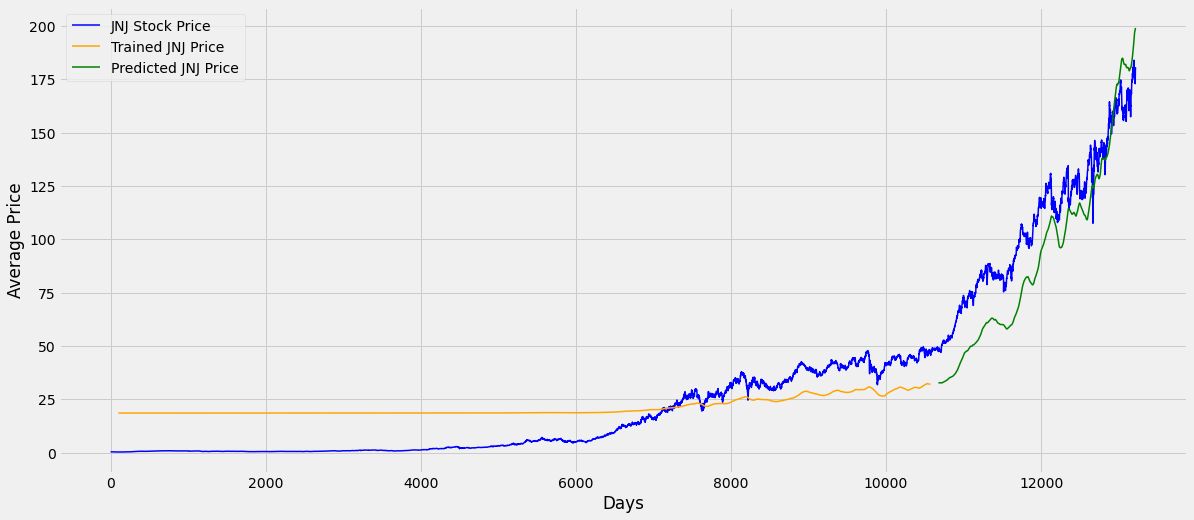

In [30]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(JNJ_partial_ds1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(JNJ_partial_ds1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(JNJ_partial_ds1)-1, :] = test_predict

# plot baseline and predictions
plt.figure(figsize=(18,8))
plt.ylabel("Average Price")
plt.xlabel("Days")
plt.plot(scaler.inverse_transform(JNJ_partial_ds1),color = 'blue',label = 'JNJ Stock Price',linewidth=1.5)
plt.plot(trainPredictPlot, color = 'orange', label = 'Trained JNJ Price',linewidth=1.5 )
plt.plot(testPredictPlot, color = 'green', label = 'Predicted JNJ Price',linewidth=1.5 )
plt.legend()
plt.show()

In [31]:
len(test_data) #Based on 100 previous days

2644

In [32]:
#Test data from 196-100(Prev 100days),so it starts from 102 day
x_input=test_data[96:].reshape(1,-1)
x_input.shape

(1, 2548)

In [33]:
#Creating list of last 100 data
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [34]:
print(len(test_data[96:]))

2548


In [35]:
print(len(temp_input))

2548


In [36]:
actual=JNJ_partial_ds1[training_size+101:len(JNJ_partial_ds1),:1]
actual=scaler.inverse_transform(actual)

predict=test_predict

In [37]:
print('   Actual                    Predicted')
print('------------------------------------------------')
for i in range(95):
    print(f'{actual[i]}  \t\t {predict[i]} ')

   Actual                    Predicted
------------------------------------------------
[47.6947855]  		 [32.67563447] 
[47.64972234]  		 [32.68319341] 
[47.76423695]  		 [32.69445756] 
[48.20345602]  		 [32.7017947] 
[48.5000096]  		 [32.70734055] 
[48.72714]  		 [32.70917978] 
[48.83601347]  		 [32.71149894] 
[48.85665678]  		 [32.71731924] 
[48.92798052]  		 [32.72600586] 
[49.05185431]  		 [32.73511627] 
[48.794716]  		 [32.74260197] 
[48.59763042]  		 [32.75105489] 
[48.6501825]  		 [32.75601434] 
[48.42681486]  		 [32.76249207] 
[48.54506512]  		 [32.76963595] 
[48.42493263]  		 [32.77683276] 
[47.98008127]  		 [32.78258678] 
[47.83743233]  		 [32.78626424] 
[47.84119194]  		 [32.78845117] 
[47.81489772]  		 [32.78773395] 
[47.71730799]  		 [32.78496921] 
[47.64034463]  		 [32.78132877] 
[47.68540161]  		 [32.77464344] 
[47.54461701]  		 [32.76550749] 
[47.78572303]  		 [32.75833852] 
[47.50712662]  		 [32.75059629] 
[47.50711082]  		 [32.74414635] 
[47.18303079]  		 [32.73581387